<a href="https://colab.research.google.com/github/Viny2030/NLP/blob/main/Bi_LSTM(Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-1-169a4a541533>:59: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  inputs = torch.LongTensor([np.asarray([word_dict[n] for n in sen.split()]) for sen in sentences])


Epoch: 1000 cost = 0.003112
Epoch: 2000 cost = 0.000658
Epoch: 3000 cost = 0.000256
Epoch: 4000 cost = 0.000124
Epoch: 5000 cost = 0.000066
sorry hate you is Bad Mean...


<ipython-input-1-169a4a541533>:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+['first_word', 'second_word', 'third_word'], fontdict={'fontsize': 14}, rotation=90)
<ipython-input-1-169a4a541533>:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+['batch_1', 'batch_2', 'batch_3', 'batch_4', 'batch_5', 'batch_6'], fontdict={'fontsize': 14})


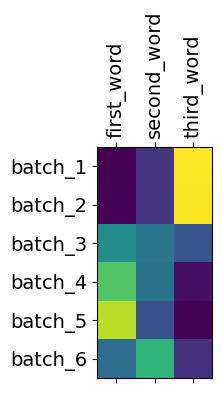

In [1]:
# code by Tae Hwan Jung(Jeff Jung) @graykode
# Reference : https://github.com/prakashpandey9/Text-Classification-Pytorch/blob/master/models/LSTM_Attn.py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

class BiLSTM_Attention(nn.Module):
    def __init__(self):
        super(BiLSTM_Attention, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, n_hidden, bidirectional=True)
        self.out = nn.Linear(n_hidden * 2, num_classes)

    # lstm_output : [batch_size, n_step, n_hidden * num_directions(=2)], F matrix
    def attention_net(self, lstm_output, final_state):
        hidden = final_state.view(-1, n_hidden * 2, 1)   # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2) # attn_weights : [batch_size, n_step]
        soft_attn_weights = F.softmax(attn_weights, 1)
        # [batch_size, n_hidden * num_directions(=2), n_step] * [batch_size, n_step, 1] = [batch_size, n_hidden * num_directions(=2), 1]
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return context, soft_attn_weights.data.numpy() # context : [batch_size, n_hidden * num_directions(=2)]

    def forward(self, X):
        input = self.embedding(X) # input : [batch_size, len_seq, embedding_dim]
        input = input.permute(1, 0, 2) # input : [len_seq, batch_size, embedding_dim]

        hidden_state = torch.zeros(1*2, len(X), n_hidden) # [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        cell_state = torch.zeros(1*2, len(X), n_hidden) # [num_layers(=1) * num_directions(=2), batch_size, n_hidden]

        # final_hidden_state, final_cell_state : [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        output, (final_hidden_state, final_cell_state) = self.lstm(input, (hidden_state, cell_state))
        output = output.permute(1, 0, 2) # output : [batch_size, len_seq, n_hidden]
        attn_output, attention = self.attention_net(output, final_hidden_state)
        return self.out(attn_output), attention # model : [batch_size, num_classes], attention : [batch_size, n_step]

if __name__ == '__main__':
    embedding_dim = 2 # embedding size
    n_hidden = 5  # number of hidden units in one cell
    num_classes = 2  # 0 or 1

    # 3 words sentences (=sequence_length is 3)
    sentences = ["i love you", "he loves me", "she likes baseball", "i hate you", "sorry for that", "this is awful"]
    labels = [1, 1, 1, 0, 0, 0]  # 1 is good, 0 is not good.

    word_list = " ".join(sentences).split()
    word_list = list(set(word_list))
    word_dict = {w: i for i, w in enumerate(word_list)}
    vocab_size = len(word_dict)

    model = BiLSTM_Attention()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    inputs = torch.LongTensor([np.asarray([word_dict[n] for n in sen.split()]) for sen in sentences])
    targets = torch.LongTensor([out for out in labels])  # To using Torch Softmax Loss function

    # Training
    for epoch in range(5000):
        optimizer.zero_grad()
        output, attention = model(inputs)
        loss = criterion(output, targets)
        if (epoch + 1) % 1000 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

        loss.backward()
        optimizer.step()

    # Test
    test_text = 'sorry hate you'
    tests = [np.asarray([word_dict[n] for n in test_text.split()])]
    test_batch = torch.LongTensor(tests)

    # Predict
    predict, _ = model(test_batch)
    predict = predict.data.max(1, keepdim=True)[1]
    if predict[0][0] == 0:
        print(test_text,"is Bad Mean...")
    else:
        print(test_text,"is Good Mean!!")

    fig = plt.figure(figsize=(6, 3)) # [batch_size, n_step]
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    ax.set_xticklabels(['']+['first_word', 'second_word', 'third_word'], fontdict={'fontsize': 14}, rotation=90)
    ax.set_yticklabels(['']+['batch_1', 'batch_2', 'batch_3', 'batch_4', 'batch_5', 'batch_6'], fontdict={'fontsize': 14})
    plt.show()